## Deep Neural Network model with OHE-PCA
*Summary:* In this notebook, we use a DNN model using PCA analysis. We use one-hot encoding for the categorical variables and reduce the dimensionality from a total of 196 features to 18 features, that retain the explanation of 95% of the variance.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

train = pd.read_csv("../dataset/UNSW_NB15_training-set.csv")
test = pd.read_csv("../dataset/UNSW_NB15_testing-set.csv")

In [3]:
df = pd.concat([train, test]).reset_index(drop=True)
labels = df['label']
df = df.drop(columns=['id', 'attack_cat', 'label'], axis=1)

# get numeric column names without label column
num_cols = df._get_numeric_data().columns

# subract numeric columns from all columns to get categorical columns 
cat_cols = list(set(df.columns) - set(num_cols))

print(f"Numerical features: {len(num_cols)}\nCategorical features: {len(cat_cols)}")

Numerical features: 39
Categorical features: 3


In [4]:
df[cat_cols] = df[cat_cols].astype('category')
for cat in cat_cols:
    df[cat] = df[cat].cat.codes

df[cat_cols]

,state,proto,service
0,5,119,0
1,5,119,0
2,5,119,0
3,5,119,0
4,5,119,0
...,...,...,...
257668,5,119,2
257669,4,113,0
257670,5,119,2
257671,5,119,2


In [5]:
from sklearn.preprocessing import MinMaxScaler

# apply min-max scaler that scales the variables in the range [0-1]
scl = MinMaxScaler()
df = scl.fit_transform(df)

In [6]:
from sklearn.decomposition import PCA

# apply principal component analysis
pca = PCA(n_components=0.95)
pca_df = pca.fit_transform(df)
pca_df = pd.DataFrame(pca_df)

pca_df

,0,1,2,3,4,5,6,7,8,9,10
0,-0.782517,-0.019278,-0.434279,-0.143849,-0.143722,-0.033623,0.053112,-0.000026,0.068036,-0.075005,0.023751
1,-0.775704,-0.034400,-0.453373,-0.119990,-0.200415,-0.045221,0.130624,0.140866,0.302216,-0.057119,-0.099826
2,-0.794653,-0.036226,-0.421886,-0.142256,-0.174053,-0.039984,0.092364,0.078309,0.138112,0.009949,-0.038697
3,-0.796393,-0.035295,-0.404071,-0.137547,-0.159845,-0.036886,0.078807,0.052981,0.119915,-0.016534,-0.022682
4,-0.779061,-0.043580,-0.425183,-0.102118,-0.205160,-0.045878,0.145981,0.171237,0.388044,-0.082036,-0.133514
...,...,...,...,...,...,...,...,...,...,...,...
257668,-1.006850,-0.187477,0.439006,0.083193,0.021705,0.005563,0.009638,-0.014605,0.018156,-0.078166,-0.018483
257669,1.145673,-0.577834,-0.089745,-0.236487,0.166209,0.049098,0.256501,-0.197499,-0.016913,0.008683,0.029062
257670,-0.843997,-0.061730,-0.169242,-0.048666,-0.118811,-0.027163,0.062178,0.038015,-0.024258,-0.082422,0.047073
257671,-1.064012,-0.231827,0.651510,0.123628,0.070601,0.016876,-0.013917,-0.035156,0.040819,-0.078037,-0.029928


In [7]:
from sklearn.model_selection import train_test_split

y = labels
X = pca_df

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=42)

X_val = X_train.iloc[-10000:]
y_val = y_train.iloc[-10000:]

X_train = X_train.iloc[:-10000]
y_train = y_train.iloc[:-10000]

(X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape)

((162640, 11), (85033, 11), (10000, 11), (162640,), (85033,), (10000,))

### Tensorflow model

In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
plt.style.use('ggplot')
!pip install livelossplot
from livelossplot import PlotLossesKeras

In [7]:
model = keras.Sequential(
    [
        layers.Dense(256, activation='relu', input_dim=X_train.shape[1]),
        layers.Dense(128, activation='relu', use_bias=True),
        layers.Dense(128, activation='relu', use_bias=True),
        layers.Dense(128, activation='relu', use_bias=True),
        layers.Dense(128, activation='relu', use_bias=True),
        layers.Dense(1, activation='sigmoid', use_bias=True)
    ]
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               4864      
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 87,425
Trainable params: 87,425
Non-traina

In [8]:
model.compile('adam', loss='binary_crossentropy', metrics='accuracy')

monitor_val_acc = EarlyStopping(monitor='loss', patience=10)
callbacks=[PlotLossesKeras()]

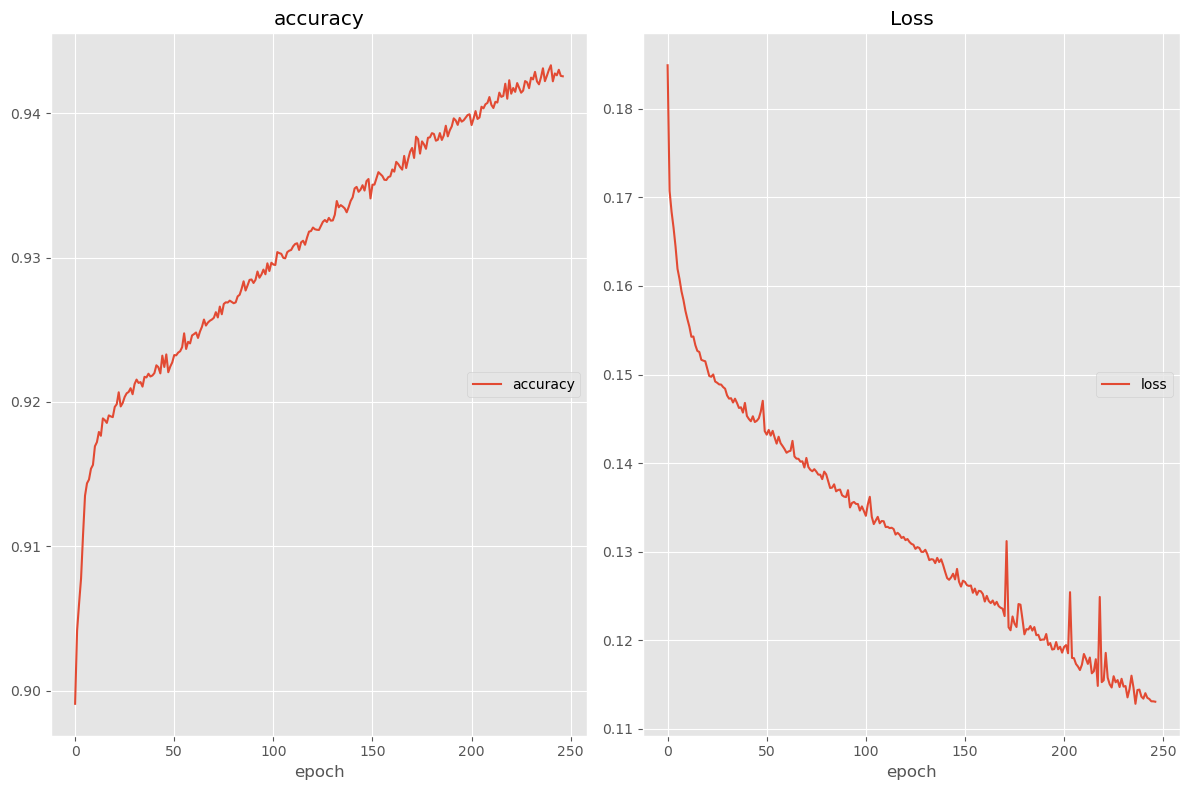

accuracy
	accuracy         	 (min:    0.899, max:    0.943, cur:    0.943)
Loss
	loss             	 (min:    0.113, max:    0.185, cur:    0.113)


In [10]:
model.fit(X_train, y_train, epochs=1000, batch_size=128, callbacks=[PlotLossesKeras(), monitor_val_acc], shuffle=1000, verbose=0)

In [11]:
model.evaluate(X_test, y_test)

2658/2658 [==============================] - 3s 1ms/step - loss: 0.1694 - accuracy: 0.9078


[0.1694270521402359, 0.9077887535095215]

In [9]:
model = keras.Sequential(
    [
        layers.Dense(256, activation='relu', input_dim=X_train.shape[1]),
        layers.Dense(128, activation='relu', use_bias=True),
        layers.Dense(128, activation='relu', use_bias=True),
        layers.Dense(128, activation='relu', use_bias=True),
        layers.Dense(128, activation='relu', use_bias=True),
        layers.Dense(1, activation='sigmoid', use_bias=True)
    ]
)
model.summary()

model.compile('adam', loss='binary_crossentropy', metrics='accuracy')
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=1000, shuffle=1000, verbose=2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               3072      
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 85,633
Trainable params: 85,633
Non-traina

In [10]:
model.evaluate(X_test, y_test)

2658/2658 [==============================] - 3s 1ms/step - loss: 0.1469 - accuracy: 0.9212


[0.14694032073020935, 0.9211717844009399]

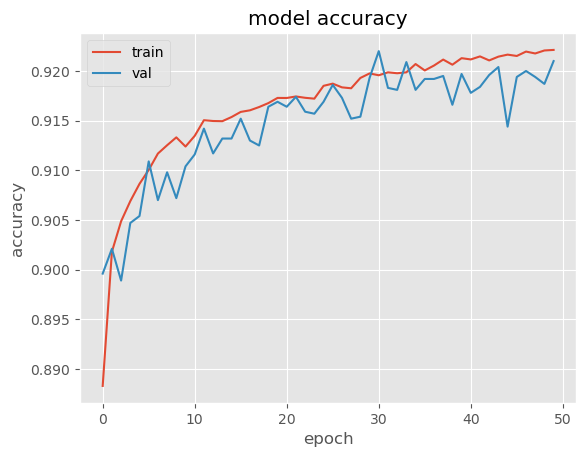

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

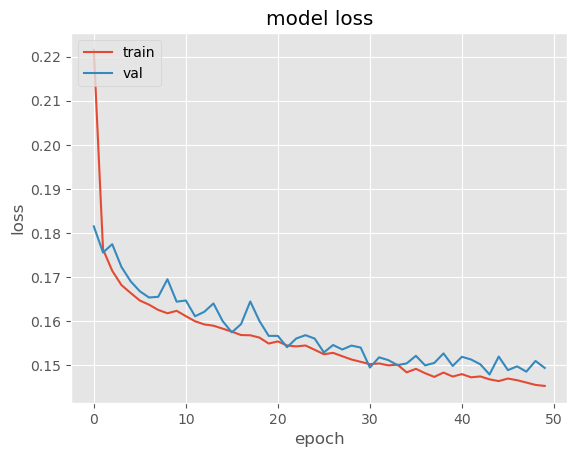

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()